In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import datetime
import copy
from tqdm import tqdm
from time import sleep
from utilsTorch import *
from dataset import *
from model import *


print(idx2label)
print(label2idx)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

{0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}
{'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


In [2]:
new_size = (448,448)
no_grids = 7
no_classes = 20
no_boxes = 2

voc_train_2007 = torchvision.datasets.VOCDetection(root="voc",year="2007",image_set="trainval",download=False)
voc_train_2012  = torchvision.datasets.VOCDetection(root="voc",year="2012",image_set="train",download=False)
voc_val = torchvision.datasets.VOCDetection(root="voc",year="2012",image_set="val",download=False)
voc_test = torchvision.datasets.VOCDetection(root="voc",year="2007",image_set="test",download=False)

In [3]:
t1=datetime.datetime.now()
voc_train_2007_annotations = createLabelsFaster(voc_train_2007,new_size,no_grids,no_boxes,no_classes)
t2=datetime.datetime.now()
diff = t2-t1   
print(f"Elapsed time is : {diff.total_seconds()} seconds ")

print(voc_train_2007_annotations.shape)

Elapsed time is : 89.689014 seconds 
(5011, 7, 7, 30)


In [4]:
t1=datetime.datetime.now()
voc_train_2012_annotations = createLabelsFaster(voc_train_2012,new_size,no_grids,no_boxes,no_classes)
t2=datetime.datetime.now()
diff = t2-t1   
print(f"Elapsed time is : {diff.total_seconds()} seconds ")

print(voc_train_2012_annotations.shape)

Elapsed time is : 112.658401 seconds 
(5717, 7, 7, 30)


In [5]:
voc_train_images = voc_train_2007.images+voc_train_2012.images
voc_train_annotations = np.append(voc_train_2007_annotations,voc_train_2012_annotations,axis=0)

In [6]:
t1=datetime.datetime.now()
voc_val_annotations = createLabelsFaster(voc_val,new_size,no_grids,no_boxes,no_classes)
t2=datetime.datetime.now()
diff = t2-t1   
print(f"Elapsed time is : {diff.total_seconds()} seconds ")

print(voc_val_annotations.shape)

Elapsed time is : 114.069572 seconds 
(5823, 7, 7, 30)


In [7]:
t1=datetime.datetime.now()
voc_test_annotations = createLabelsFaster(voc_test,new_size,no_grids,no_boxes,no_classes)
t2=datetime.datetime.now()
diff = t2-t1   
print(f"Elapsed time is : {diff.total_seconds()} seconds ")

print(voc_test_annotations.shape)

Elapsed time is : 83.701542 seconds 
(4952, 7, 7, 30)


0 torch.Size([3, 448, 448]) torch.Size([7, 7, 30])


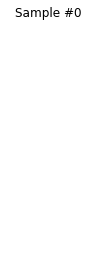

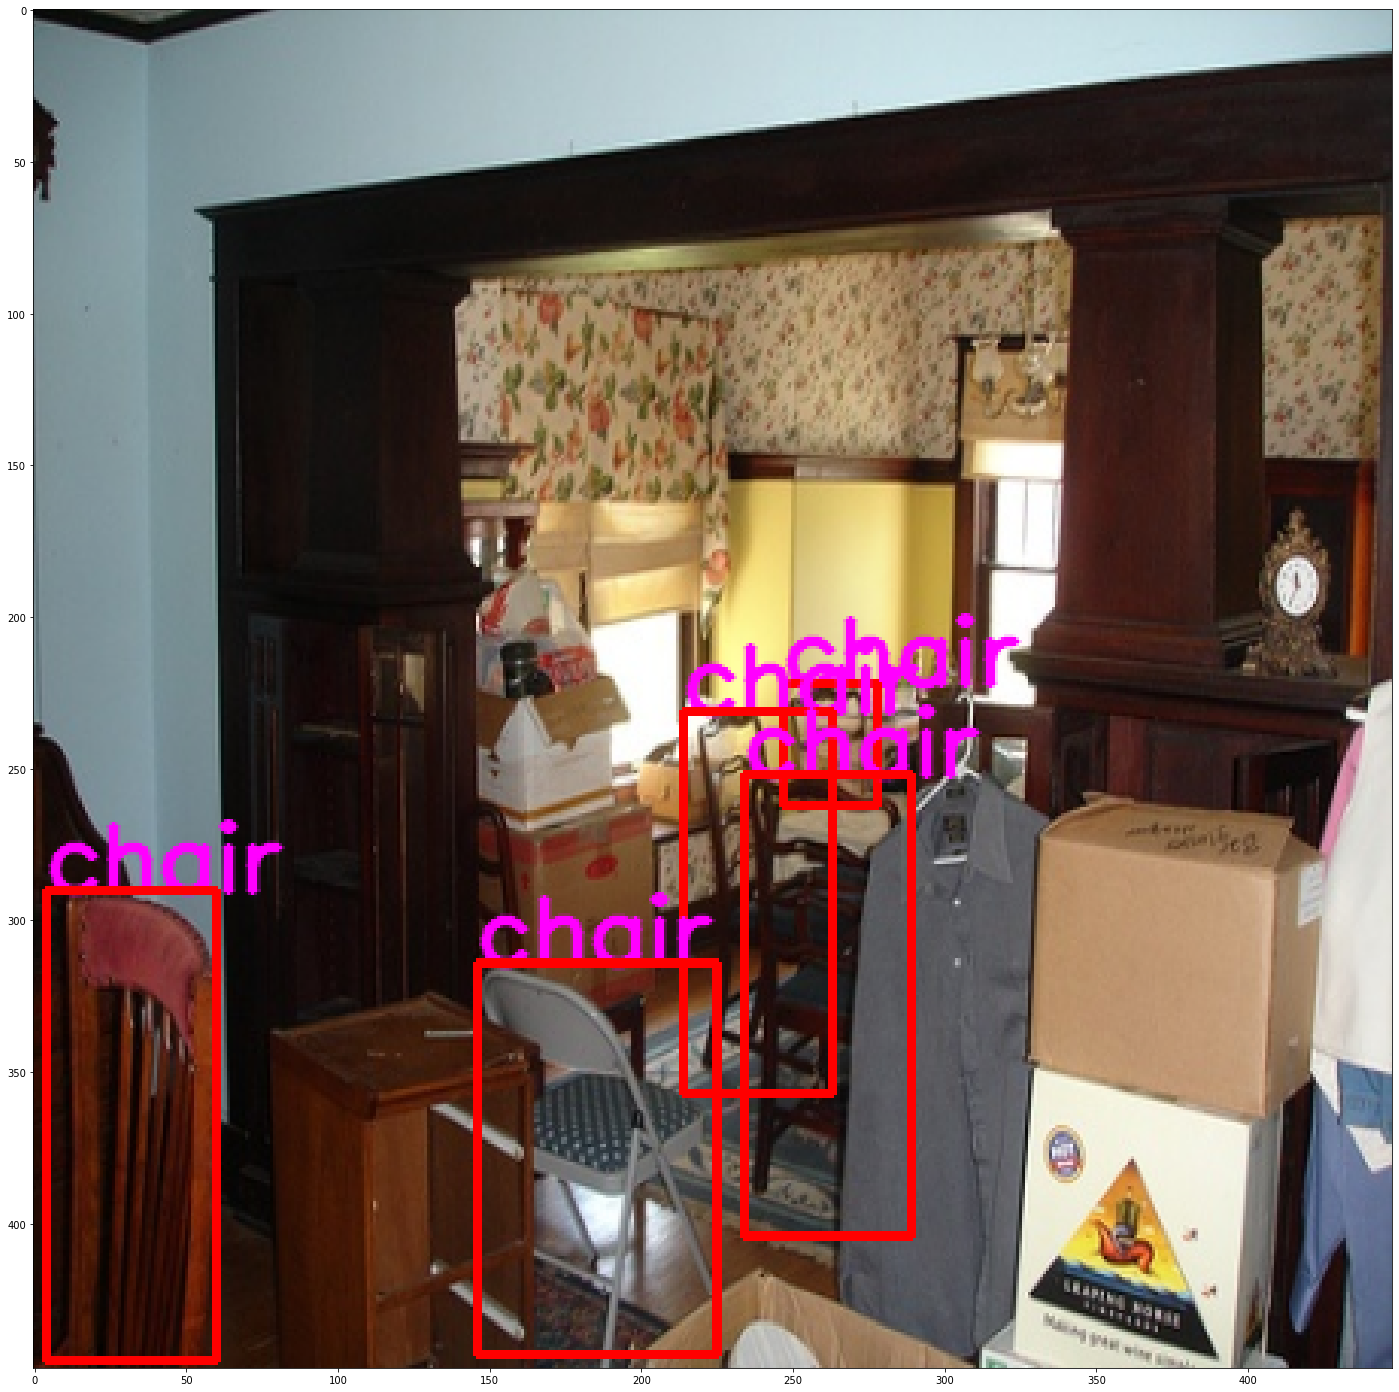

1 torch.Size([3, 448, 448]) torch.Size([7, 7, 30])


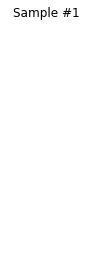

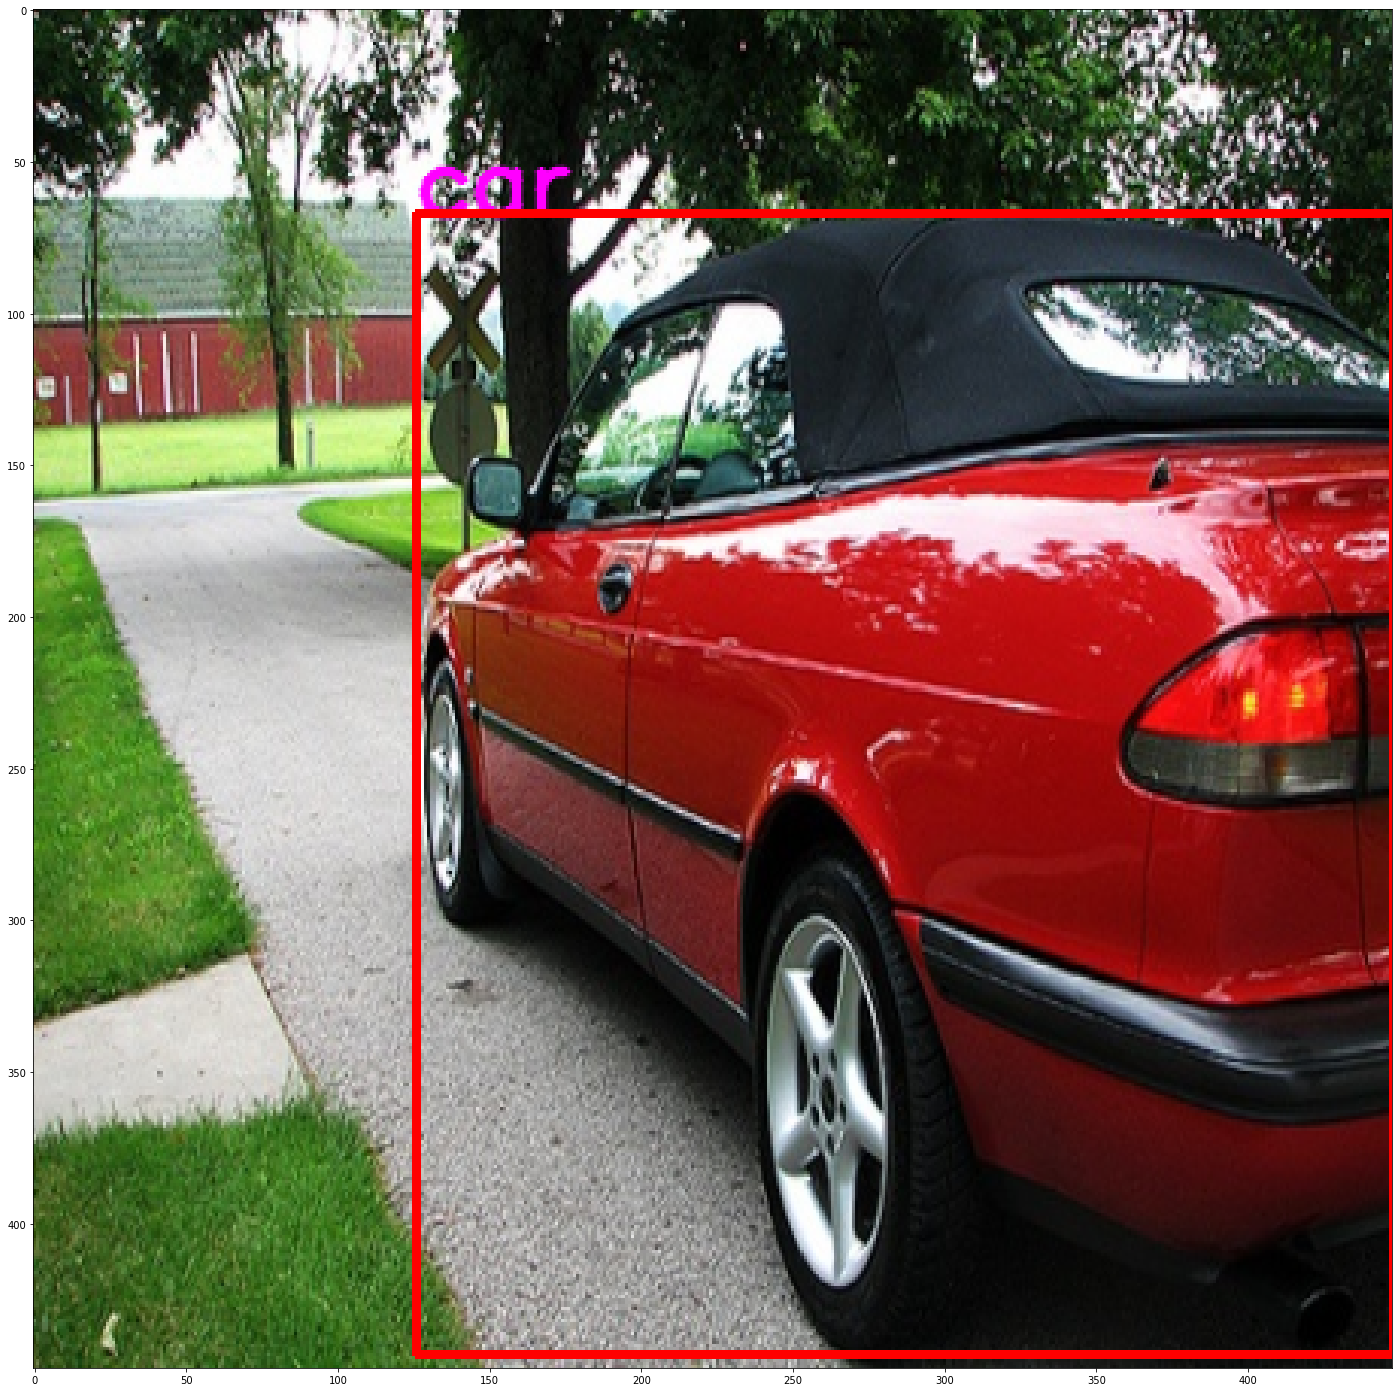

2 torch.Size([3, 448, 448]) torch.Size([7, 7, 30])


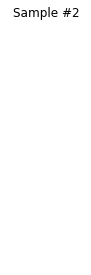

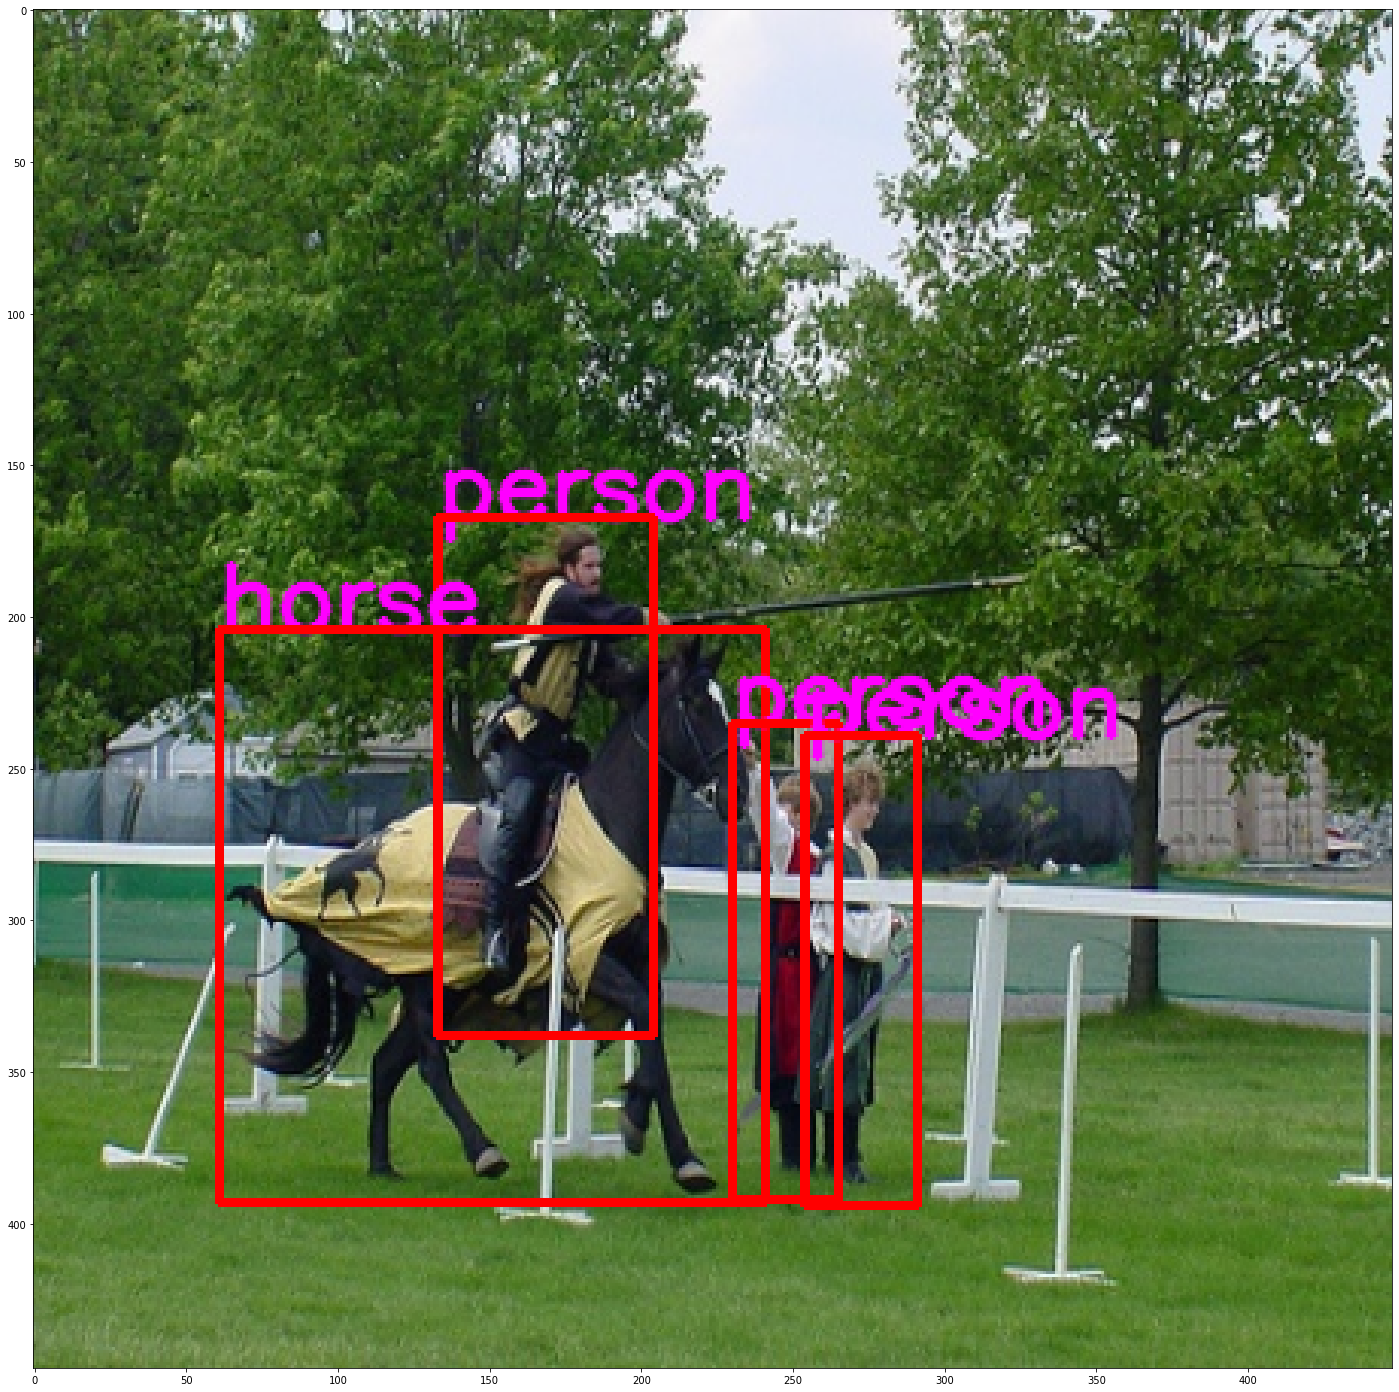

3 torch.Size([3, 448, 448]) torch.Size([7, 7, 30])


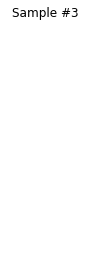

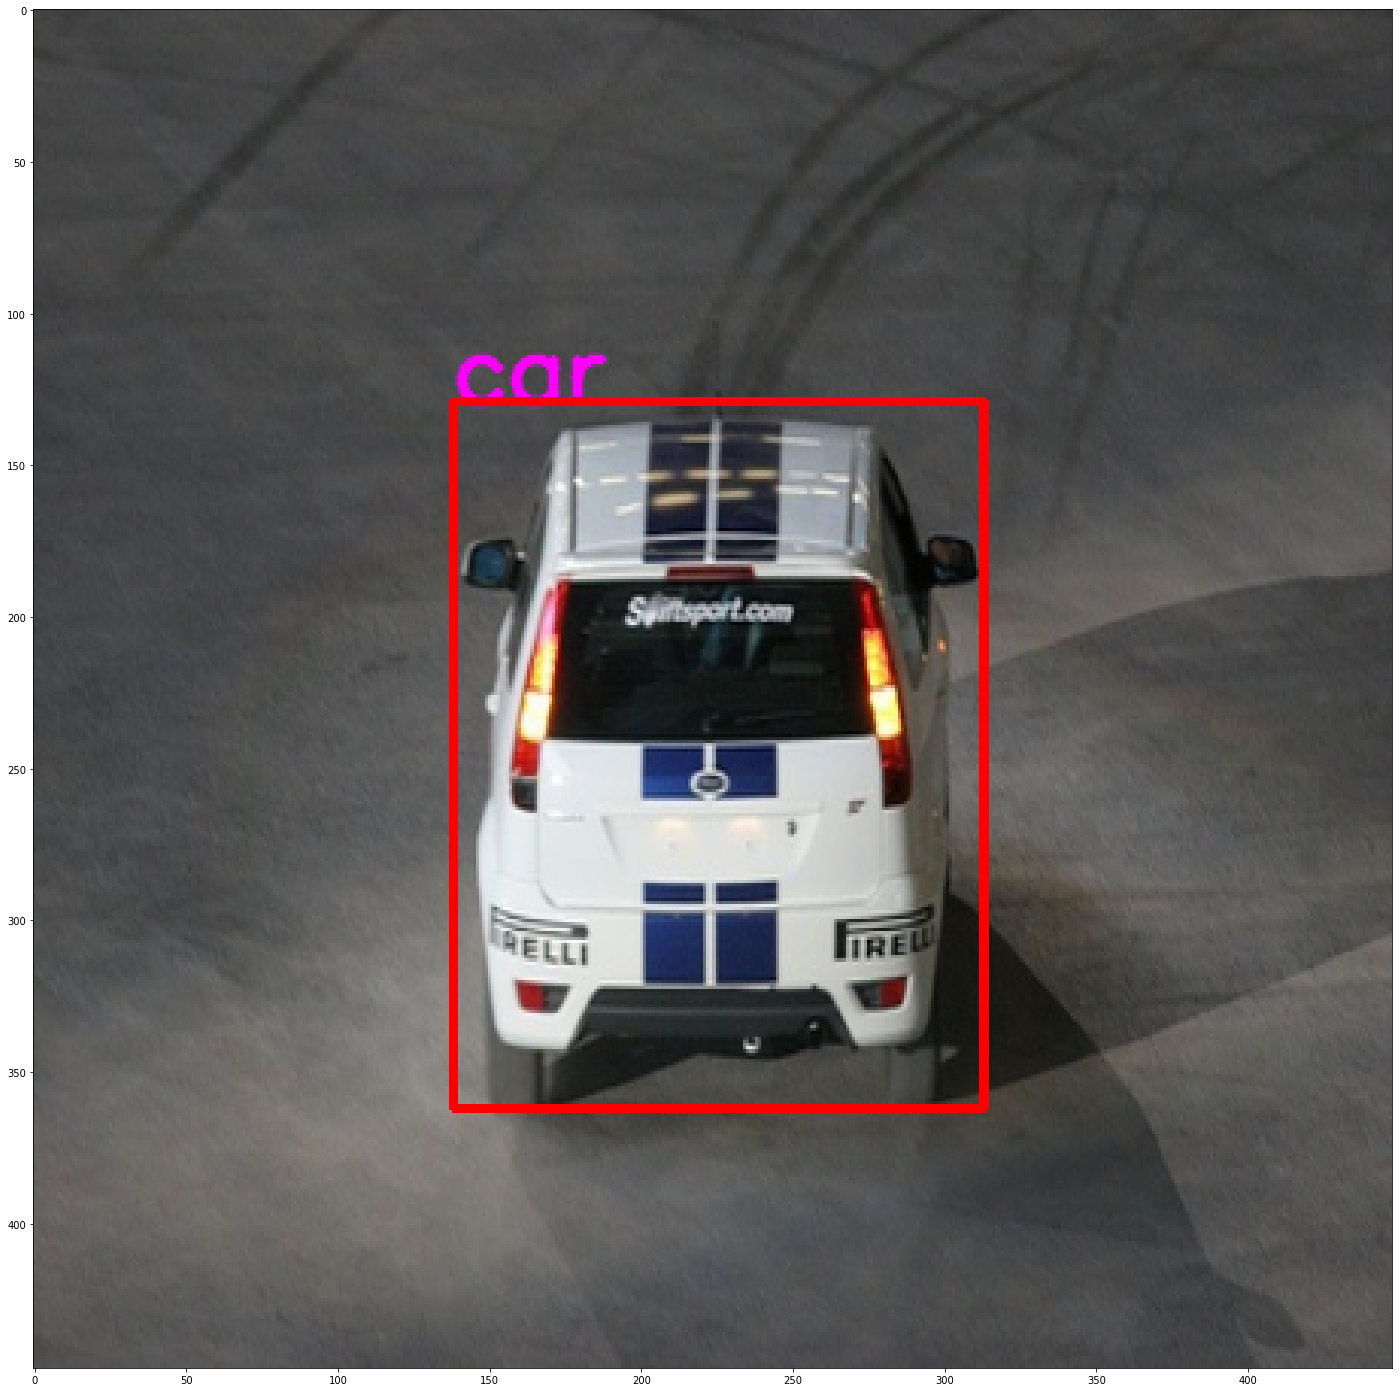

In [8]:
train = VOCDataset(voc_train_annotations,voc_train_images,transform=transforms.Compose([
                                               Rescale((448,448)),ToTensor()
                                           ]))
val = VOCDataset(voc_val_annotations,voc_val.images,transform=transforms.Compose([
                                               Rescale((448,448)),ToTensor()
                                           ]))

test = VOCDataset(voc_test_annotations,voc_test.images,transform=transforms.Compose([
                                               Rescale((448,448)),
                                            ToTensor()
                                           ]))
data = train
fig = plt.figure()

for i in range(len(data)):
    sample = data[i]

    print(i, sample['image'].shape, sample['annotation'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    showSample(sample)

    if i == 3:
        plt.show()
        break

0 torch.Size([64, 3, 448, 448]) torch.Size([64, 7, 7, 30])
1 torch.Size([64, 3, 448, 448]) torch.Size([64, 7, 7, 30])
2 torch.Size([64, 3, 448, 448]) torch.Size([64, 7, 7, 30])
3 torch.Size([64, 3, 448, 448]) torch.Size([64, 7, 7, 30])


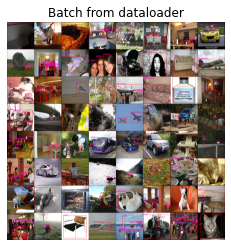

In [9]:
batch_size = 64
epochs = 5
trainLoaders = {}


trainLoader = DataLoader(train, batch_size,
                        shuffle=True, num_workers=2)

valLoader = DataLoader(val, batch_size,
                        shuffle=True, num_workers=2)

testLoader = DataLoader(test, batch_size=batch_size,
                        shuffle=False, num_workers=2)


trainLoaders["train"] = trainLoader
trainLoaders["val"] = valLoader

for i_batch, sample_batched in enumerate(trainLoader):
    print(i_batch, sample_batched['image'].size(),
            sample_batched['annotation'].size())

    if i_batch == 3:
        plt.figure()
        show_annotations_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [10]:
model = YOLOv1().to(device)

inputs = torch.zeros((2,3,448,448)).to(device)
labels = torch.zeros((2,7,7,30)).to(device)

inputs[0] = train[0]["image"]
inputs[1] = train[1]["image"]

labels[0] = train[0]["annotation"]
labels[1] = train[1]["annotation"]

preds = model(inputs/255).view(labels.shape)

yoloLossFaster(labels.float(),preds.float(),5,0.5)

tensor(61.8379, grad_fn=<AddBackward0>)

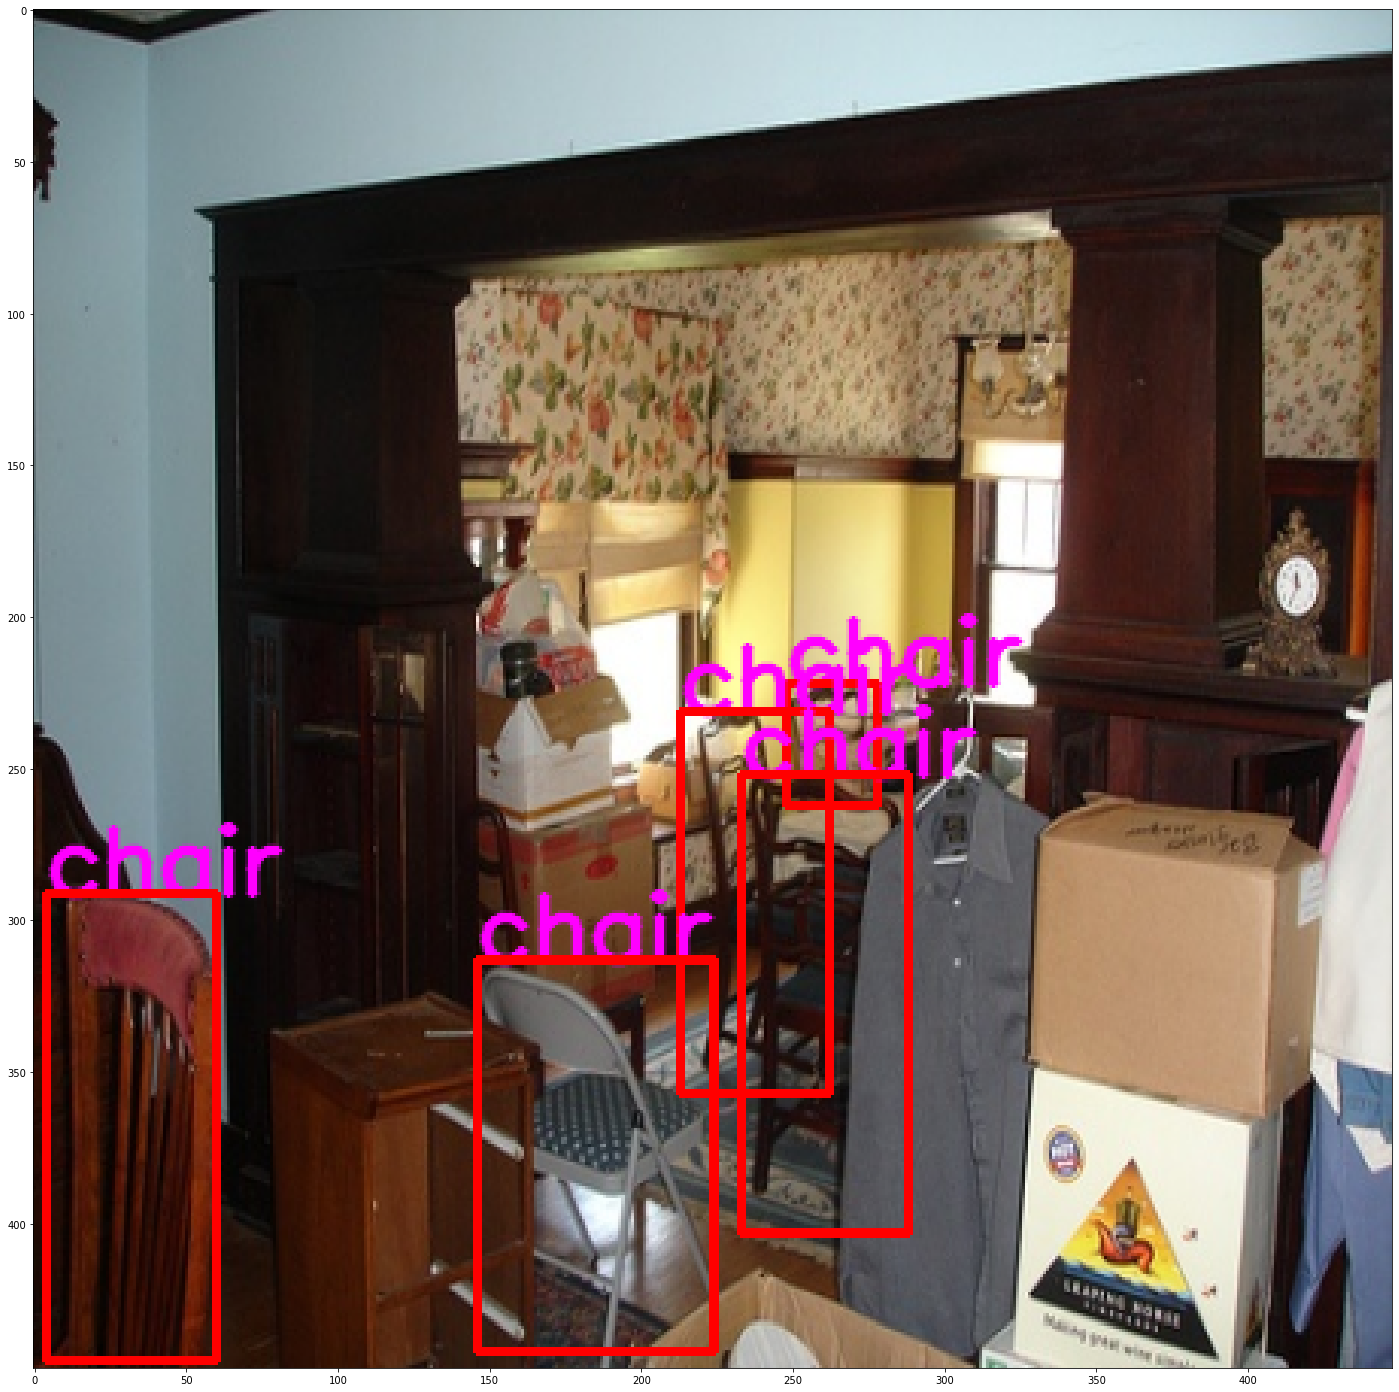

(1.0, 6, 0, 190, 0)

In [29]:
sample ={"image":train[0]["image"],"annotation":labels[0]}
showSample(sample)
accuracy(labels.float(),labels.float())

In [11]:
optimizer = optim.Adam(model.parameters(),lr = 0.0001)

In [12]:
params_to_update = model.parameters()
print("Params to learn:")
s = 0
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        s+=param.data.reshape(-1).shape[0]
        print("\t",name)

print(s)

Params to learn:
	 conv.0.weight
	 conv.0.bias
	 conv.1.weight
	 conv.1.bias
	 conv.2.weight
	 conv.2.bias
	 conv.3.weight
	 conv.3.bias
	 conv.4.weight
	 conv.4.bias
	 conv.5.weight
	 conv.5.bias
	 fc1.weight
	 fc1.bias
	 predictor.weight
	 predictor.bias
50337214


In [19]:
def train_model(model, optimizer, num_epochs=1, device = "cpu"):
    since = datetime.datetime.now()
    
    loss_val_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for i,data in enumerate(tqdm(trainLoaders[phase])):

                inputs = data["image"].to(device)
                labels = data["annotation"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):

                    # forward
                    outputs =  model(inputs/255).view(labels.shape)
                    loss = yoloLossFaster(labels.float(),outputs.float(),5,0.5)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                print(f' Loss: {loss.item()}')

        epoch_loss = running_loss / len(trainLoaders[phase])

        print('Loss: {:.4f}'.format(epoch_loss))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val':
            loss_val_history.append(epoch_loss)

    print()

    time_elapsed = (datetime.datetime.now() - since).total_seconds()
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_val_history

In [20]:
model,val_history = train_model(model,optimizer,device = device)

Epoch 0/0
----------


  1%|▍                                                                                 | 1/168 [00:12<34:51, 12.53s/it]

 Loss: 1657.358154296875


  1%|▉                                                                                 | 2/168 [00:21<28:48, 10.41s/it]

 Loss: 3464.0843505859375


  2%|█▍                                                                                | 3/168 [00:30<26:29,  9.64s/it]

 Loss: 5195.6593017578125


  2%|█▉                                                                                | 4/168 [00:38<25:12,  9.22s/it]

 Loss: 6636.56201171875


  3%|██▍                                                                               | 5/168 [00:47<24:28,  9.01s/it]

 Loss: 7982.966796875


  4%|██▉                                                                               | 6/168 [00:55<23:54,  8.86s/it]

 Loss: 9155.36669921875


  4%|███▍                                                                              | 7/168 [01:04<23:28,  8.75s/it]

 Loss: 10242.348754882812


  5%|███▉                                                                              | 8/168 [01:13<23:27,  8.80s/it]

 Loss: 11211.503173828125


  5%|████▍                                                                             | 9/168 [01:22<23:50,  9.00s/it]

 Loss: 12204.766052246094


  6%|████▊                                                                            | 10/168 [01:31<23:41,  9.00s/it]

 Loss: 13052.642883300781


  7%|█████▎                                                                           | 11/168 [01:40<23:15,  8.89s/it]

 Loss: 13689.382629394531


  7%|█████▊                                                                           | 12/168 [01:49<22:55,  8.82s/it]

 Loss: 14268.306457519531


  8%|██████▎                                                                          | 13/168 [01:57<22:32,  8.73s/it]

 Loss: 14948.669738769531


  8%|██████▊                                                                          | 14/168 [02:06<22:32,  8.78s/it]

 Loss: 15345.680358886719


  9%|███████▏                                                                         | 15/168 [02:15<22:27,  8.81s/it]

 Loss: 15795.563720703125


 10%|███████▋                                                                         | 16/168 [02:24<22:26,  8.86s/it]

 Loss: 16168.892181396484


 10%|████████▏                                                                        | 17/168 [02:33<22:25,  8.91s/it]

 Loss: 16629.645050048828


 11%|████████▋                                                                        | 18/168 [02:42<22:19,  8.93s/it]

 Loss: 17082.960418701172


 11%|█████████▏                                                                       | 19/168 [02:52<22:50,  9.20s/it]

 Loss: 17475.688232421875


 12%|█████████▋                                                                       | 20/168 [03:01<22:49,  9.25s/it]

 Loss: 17826.388885498047


 12%|██████████▏                                                                      | 21/168 [03:12<23:41,  9.67s/it]

 Loss: 18143.329498291016


 13%|██████████▌                                                                      | 22/168 [03:21<23:19,  9.59s/it]

 Loss: 18460.181671142578


 14%|███████████                                                                      | 23/168 [03:30<22:51,  9.46s/it]

 Loss: 18728.624389648438


 14%|███████████▌                                                                     | 24/168 [03:40<22:34,  9.41s/it]

 Loss: 19017.32080078125


 15%|████████████                                                                     | 25/168 [03:49<22:08,  9.29s/it]

 Loss: 19320.75958251953


 15%|████████████▌                                                                    | 26/168 [03:58<21:51,  9.24s/it]

 Loss: 19627.4521484375


 16%|█████████████                                                                    | 27/168 [04:07<21:39,  9.22s/it]

 Loss: 19880.720779418945


 17%|█████████████▌                                                                   | 28/168 [04:16<21:30,  9.22s/it]

 Loss: 20152.876510620117


 17%|█████████████▉                                                                   | 29/168 [04:25<21:15,  9.17s/it]

 Loss: 20436.806533813477


 18%|██████████████▍                                                                  | 30/168 [04:34<21:05,  9.17s/it]

 Loss: 20687.255447387695


 18%|██████████████▉                                                                  | 31/168 [04:43<20:52,  9.14s/it]

 Loss: 20913.171630859375


 19%|███████████████▍                                                                 | 32/168 [04:53<20:41,  9.13s/it]

 Loss: 21163.070724487305


 20%|███████████████▉                                                                 | 33/168 [05:02<20:34,  9.14s/it]

 Loss: 21449.734970092773


 20%|████████████████▍                                                                | 34/168 [05:11<20:21,  9.12s/it]

 Loss: 21732.630661010742


 21%|████████████████▉                                                                | 35/168 [05:20<20:11,  9.11s/it]

 Loss: 22021.904067993164


 21%|█████████████████▎                                                               | 36/168 [05:29<20:06,  9.14s/it]

 Loss: 22268.539840698242


 22%|█████████████████▊                                                               | 37/168 [05:38<19:57,  9.14s/it]

 Loss: 22555.445236206055


 23%|██████████████████▎                                                              | 38/168 [05:47<19:48,  9.14s/it]

 Loss: 22784.42137145996


 23%|██████████████████▊                                                              | 39/168 [05:56<19:36,  9.12s/it]

 Loss: 23031.095642089844


 24%|███████████████████▎                                                             | 40/168 [06:06<19:31,  9.15s/it]

 Loss: 23280.48583984375


 24%|███████████████████▊                                                             | 41/168 [06:15<19:20,  9.14s/it]

 Loss: 23540.376220703125


 25%|████████████████████▎                                                            | 42/168 [06:24<19:12,  9.15s/it]

 Loss: 23797.061950683594


 26%|████████████████████▋                                                            | 43/168 [06:33<19:05,  9.16s/it]

 Loss: 24060.720336914062


 26%|█████████████████████▏                                                           | 44/168 [06:42<18:53,  9.14s/it]

 Loss: 24260.113708496094


 27%|█████████████████████▋                                                           | 45/168 [06:51<18:47,  9.17s/it]

 Loss: 24495.65003967285


 27%|██████████████████████▏                                                          | 46/168 [07:01<18:34,  9.14s/it]

 Loss: 24733.456665039062


 28%|██████████████████████▋                                                          | 47/168 [07:10<18:49,  9.33s/it]

 Loss: 24963.26969909668


 29%|███████████████████████▏                                                         | 48/168 [07:20<18:54,  9.45s/it]

 Loss: 25215.997482299805


 29%|███████████████████████▋                                                         | 49/168 [07:29<18:40,  9.41s/it]

 Loss: 25455.54359436035


 30%|████████████████████████                                                         | 50/168 [07:39<18:26,  9.38s/it]

 Loss: 25683.93280029297


 30%|████████████████████████▌                                                        | 51/168 [07:48<18:25,  9.44s/it]

 Loss: 25905.063858032227


 31%|█████████████████████████                                                        | 52/168 [07:58<18:29,  9.56s/it]

 Loss: 26142.090591430664


 32%|█████████████████████████▌                                                       | 53/168 [08:07<18:11,  9.49s/it]

 Loss: 26355.122665405273


 32%|██████████████████████████                                                       | 54/168 [08:17<17:56,  9.44s/it]

 Loss: 26596.470809936523


 33%|██████████████████████████▌                                                      | 55/168 [08:26<17:33,  9.32s/it]

 Loss: 26773.614990234375


 33%|███████████████████████████                                                      | 56/168 [08:35<17:16,  9.25s/it]

 Loss: 27082.982666015625


 34%|███████████████████████████▍                                                     | 57/168 [08:44<16:57,  9.17s/it]

 Loss: 27320.17283630371


 35%|███████████████████████████▉                                                     | 58/168 [08:53<16:45,  9.14s/it]

 Loss: 27530.632614135742


 35%|████████████████████████████▍                                                    | 59/168 [09:02<16:34,  9.12s/it]

 Loss: 27769.796463012695


 36%|████████████████████████████▉                                                    | 60/168 [09:11<16:27,  9.14s/it]

 Loss: 27979.23452758789


 36%|█████████████████████████████▍                                                   | 61/168 [09:20<16:19,  9.15s/it]

 Loss: 28199.88722229004


 37%|█████████████████████████████▉                                                   | 62/168 [09:29<16:06,  9.12s/it]

 Loss: 28386.732482910156


 38%|██████████████████████████████▍                                                  | 63/168 [09:39<15:57,  9.12s/it]

 Loss: 28620.908004760742


 38%|██████████████████████████████▊                                                  | 64/168 [09:48<15:53,  9.17s/it]

 Loss: 28807.580673217773


 39%|███████████████████████████████▎                                                 | 65/168 [09:57<15:42,  9.15s/it]

 Loss: 29027.07972717285


 39%|███████████████████████████████▊                                                 | 66/168 [10:06<15:31,  9.14s/it]

 Loss: 29260.79527282715


 40%|████████████████████████████████▎                                                | 67/168 [10:15<15:18,  9.09s/it]

 Loss: 29486.256881713867


 40%|████████████████████████████████▊                                                | 68/168 [10:24<15:07,  9.08s/it]

 Loss: 29707.173080444336


 41%|█████████████████████████████████▎                                               | 69/168 [10:33<14:56,  9.06s/it]

 Loss: 29938.538864135742


 42%|█████████████████████████████████▊                                               | 70/168 [10:42<14:47,  9.06s/it]

 Loss: 30155.364013671875


 42%|██████████████████████████████████▏                                              | 71/168 [10:51<14:39,  9.07s/it]

 Loss: 30369.39323425293


 43%|██████████████████████████████████▋                                              | 72/168 [11:00<14:30,  9.07s/it]

 Loss: 30549.552352905273


 43%|███████████████████████████████████▏                                             | 73/168 [11:09<14:22,  9.08s/it]

 Loss: 30787.551803588867


 44%|███████████████████████████████████▋                                             | 74/168 [11:18<14:10,  9.05s/it]

 Loss: 31035.324661254883


 45%|████████████████████████████████████▏                                            | 75/168 [11:28<14:04,  9.08s/it]

 Loss: 31260.4139251709


 45%|████████████████████████████████████▋                                            | 76/168 [11:37<14:19,  9.34s/it]

 Loss: 31456.261962890625


 46%|█████████████████████████████████████▏                                           | 77/168 [11:47<14:16,  9.41s/it]

 Loss: 31646.700637817383


 46%|█████████████████████████████████████▌                                           | 78/168 [11:56<14:00,  9.34s/it]

 Loss: 31879.28660583496


 47%|██████████████████████████████████████                                           | 79/168 [12:05<13:45,  9.27s/it]

 Loss: 32089.610244750977


 48%|██████████████████████████████████████▌                                          | 80/168 [12:14<13:32,  9.23s/it]

 Loss: 32274.30435180664


 48%|███████████████████████████████████████                                          | 81/168 [12:24<13:19,  9.19s/it]

 Loss: 32481.861419677734


 49%|███████████████████████████████████████▌                                         | 82/168 [12:33<13:06,  9.14s/it]

 Loss: 32763.140502929688


 49%|████████████████████████████████████████                                         | 83/168 [12:42<12:56,  9.13s/it]

 Loss: 32965.658752441406


 50%|████████████████████████████████████████▌                                        | 84/168 [12:51<12:48,  9.14s/it]

 Loss: 33138.83169555664


 51%|████████████████████████████████████████▉                                        | 85/168 [13:00<12:36,  9.11s/it]

 Loss: 33364.70397949219


 51%|█████████████████████████████████████████▍                                       | 86/168 [13:09<12:27,  9.11s/it]

 Loss: 33599.644607543945


 52%|█████████████████████████████████████████▉                                       | 87/168 [13:18<12:14,  9.07s/it]

 Loss: 33812.08106994629


 52%|██████████████████████████████████████████▍                                      | 88/168 [13:27<12:02,  9.03s/it]

 Loss: 34043.62422180176


 53%|██████████████████████████████████████████▉                                      | 89/168 [13:36<11:51,  9.00s/it]

 Loss: 34266.2234954834


 54%|███████████████████████████████████████████▍                                     | 90/168 [13:45<11:40,  8.98s/it]

 Loss: 34524.93293762207


 54%|███████████████████████████████████████████▉                                     | 91/168 [13:54<11:31,  8.98s/it]

 Loss: 34711.41499328613


 55%|████████████████████████████████████████████▎                                    | 92/168 [14:03<11:21,  8.97s/it]

 Loss: 34923.9479675293


 55%|████████████████████████████████████████████▊                                    | 93/168 [14:12<11:13,  8.98s/it]

 Loss: 35157.14646911621


 56%|█████████████████████████████████████████████▎                                   | 94/168 [14:21<11:08,  9.04s/it]

 Loss: 35366.626876831055


 57%|█████████████████████████████████████████████▊                                   | 95/168 [14:30<11:04,  9.10s/it]

 Loss: 35550.33399963379


 57%|██████████████████████████████████████████████▎                                  | 96/168 [14:39<10:58,  9.14s/it]

 Loss: 35747.58122253418


 58%|██████████████████████████████████████████████▊                                  | 97/168 [14:48<10:47,  9.12s/it]

 Loss: 35944.78628540039


 58%|███████████████████████████████████████████████▎                                 | 98/168 [14:58<10:38,  9.12s/it]

 Loss: 36140.8623046875


 59%|███████████████████████████████████████████████▋                                 | 99/168 [15:07<10:26,  9.08s/it]

 Loss: 36378.06034851074


 60%|███████████████████████████████████████████████▌                                | 100/168 [15:16<10:15,  9.04s/it]

 Loss: 36601.09272766113


 60%|████████████████████████████████████████████████                                | 101/168 [15:25<10:07,  9.07s/it]

 Loss: 36798.26594543457


 61%|████████████████████████████████████████████████▌                               | 102/168 [15:34<10:03,  9.15s/it]

 Loss: 36995.89045715332


 61%|█████████████████████████████████████████████████                               | 103/168 [15:43<09:52,  9.12s/it]

 Loss: 37199.551345825195


 62%|█████████████████████████████████████████████████▌                              | 104/168 [15:52<09:42,  9.09s/it]

 Loss: 37404.79214477539


 62%|██████████████████████████████████████████████████                              | 105/168 [16:01<09:35,  9.13s/it]

 Loss: 37647.54333496094


 63%|██████████████████████████████████████████████████▍                             | 106/168 [16:11<09:34,  9.26s/it]

 Loss: 37840.359619140625


 64%|██████████████████████████████████████████████████▉                             | 107/168 [16:20<09:28,  9.32s/it]

 Loss: 38035.462631225586


 64%|███████████████████████████████████████████████████▍                            | 108/168 [16:29<09:14,  9.24s/it]

 Loss: 38278.73498535156


 65%|███████████████████████████████████████████████████▉                            | 109/168 [16:38<09:02,  9.19s/it]

 Loss: 38491.994720458984


 65%|████████████████████████████████████████████████████▍                           | 110/168 [16:48<08:52,  9.18s/it]

 Loss: 38698.69239807129


 66%|████████████████████████████████████████████████████▊                           | 111/168 [16:57<08:40,  9.13s/it]

 Loss: 38864.499099731445


 67%|█████████████████████████████████████████████████████▎                          | 112/168 [17:06<08:32,  9.14s/it]

 Loss: 39041.37309265137


 67%|█████████████████████████████████████████████████████▊                          | 113/168 [17:15<08:31,  9.30s/it]

 Loss: 39249.73304748535


 68%|██████████████████████████████████████████████████████▎                         | 114/168 [17:25<08:28,  9.42s/it]

 Loss: 39496.30766296387


 68%|██████████████████████████████████████████████████████▊                         | 115/168 [17:34<08:13,  9.31s/it]

 Loss: 39745.478103637695


 69%|███████████████████████████████████████████████████████▏                        | 116/168 [17:43<07:59,  9.23s/it]

 Loss: 39931.817642211914


 70%|███████████████████████████████████████████████████████▋                        | 117/168 [17:52<07:48,  9.19s/it]

 Loss: 40144.1326751709


 70%|████████████████████████████████████████████████████████▏                       | 118/168 [18:01<07:36,  9.13s/it]

 Loss: 40332.026107788086


 71%|████████████████████████████████████████████████████████▋                       | 119/168 [18:10<07:26,  9.10s/it]

 Loss: 40547.05171203613


 71%|█████████████████████████████████████████████████████████▏                      | 120/168 [18:20<07:24,  9.25s/it]

 Loss: 40734.353286743164


 72%|█████████████████████████████████████████████████████████▌                      | 121/168 [18:29<07:13,  9.23s/it]

 Loss: 40959.92578125


 73%|██████████████████████████████████████████████████████████                      | 122/168 [18:38<07:03,  9.20s/it]

 Loss: 41144.565505981445


 73%|██████████████████████████████████████████████████████████▌                     | 123/168 [18:48<07:00,  9.34s/it]

 Loss: 41342.530197143555


 74%|███████████████████████████████████████████████████████████                     | 124/168 [18:57<06:45,  9.22s/it]

 Loss: 41548.76533508301


 74%|███████████████████████████████████████████████████████████▌                    | 125/168 [19:06<06:33,  9.15s/it]

 Loss: 41744.21887207031


 75%|████████████████████████████████████████████████████████████                    | 126/168 [19:15<06:23,  9.13s/it]

 Loss: 41939.116958618164


 76%|████████████████████████████████████████████████████████████▍                   | 127/168 [19:24<06:15,  9.16s/it]

 Loss: 42116.2033996582


 76%|████████████████████████████████████████████████████████████▉                   | 128/168 [19:33<06:05,  9.14s/it]

 Loss: 42301.2297668457


 77%|█████████████████████████████████████████████████████████████▍                  | 129/168 [19:42<05:54,  9.09s/it]

 Loss: 42503.94860839844


 77%|█████████████████████████████████████████████████████████████▉                  | 130/168 [19:51<05:44,  9.06s/it]

 Loss: 42673.63902282715


 78%|██████████████████████████████████████████████████████████████▍                 | 131/168 [20:00<05:35,  9.06s/it]

 Loss: 42843.176345825195


 79%|██████████████████████████████████████████████████████████████▊                 | 132/168 [20:09<05:26,  9.06s/it]

 Loss: 43070.180099487305


 79%|███████████████████████████████████████████████████████████████▎                | 133/168 [20:19<05:18,  9.09s/it]

 Loss: 43285.420181274414


 80%|███████████████████████████████████████████████████████████████▊                | 134/168 [20:28<05:08,  9.07s/it]

 Loss: 43475.98765563965


 80%|████████████████████████████████████████████████████████████████▎               | 135/168 [20:37<04:58,  9.05s/it]

 Loss: 43651.53634643555


 81%|████████████████████████████████████████████████████████████████▊               | 136/168 [20:46<04:49,  9.03s/it]

 Loss: 43848.697525024414


 82%|█████████████████████████████████████████████████████████████████▏              | 137/168 [20:55<04:39,  9.03s/it]

 Loss: 44080.894958496094


 82%|█████████████████████████████████████████████████████████████████▋              | 138/168 [21:04<04:36,  9.21s/it]

 Loss: 44284.16955566406


 83%|██████████████████████████████████████████████████████████████████▏             | 139/168 [21:13<04:27,  9.23s/it]

 Loss: 44470.65740966797


 83%|██████████████████████████████████████████████████████████████████▋             | 140/168 [21:23<04:17,  9.21s/it]

 Loss: 44687.380798339844


 84%|███████████████████████████████████████████████████████████████████▏            | 141/168 [21:32<04:10,  9.29s/it]

 Loss: 44894.65492248535


 85%|███████████████████████████████████████████████████████████████████▌            | 142/168 [21:41<04:00,  9.27s/it]

 Loss: 45134.390853881836


 85%|████████████████████████████████████████████████████████████████████            | 143/168 [21:50<03:50,  9.23s/it]

 Loss: 45329.13832092285


 86%|████████████████████████████████████████████████████████████████████▌           | 144/168 [22:00<03:45,  9.41s/it]

 Loss: 45517.2540435791


 86%|█████████████████████████████████████████████████████████████████████           | 145/168 [22:10<03:36,  9.41s/it]

 Loss: 45712.47898864746


 87%|█████████████████████████████████████████████████████████████████████▌          | 146/168 [22:19<03:25,  9.33s/it]

 Loss: 45896.72132873535


 88%|██████████████████████████████████████████████████████████████████████          | 147/168 [22:28<03:13,  9.23s/it]

 Loss: 46081.828521728516


 88%|██████████████████████████████████████████████████████████████████████▍         | 148/168 [22:37<03:02,  9.14s/it]

 Loss: 46271.54188537598


 89%|██████████████████████████████████████████████████████████████████████▉         | 149/168 [22:46<02:53,  9.12s/it]

 Loss: 46461.97444152832


 89%|███████████████████████████████████████████████████████████████████████▍        | 150/168 [22:55<02:44,  9.12s/it]

 Loss: 46649.09197998047


 90%|███████████████████████████████████████████████████████████████████████▉        | 151/168 [23:04<02:35,  9.14s/it]

 Loss: 46813.174087524414


 90%|████████████████████████████████████████████████████████████████████████▍       | 152/168 [23:13<02:25,  9.12s/it]

 Loss: 47018.0457611084


 91%|████████████████████████████████████████████████████████████████████████▊       | 153/168 [23:23<02:17,  9.19s/it]

 Loss: 47243.49919128418


 92%|█████████████████████████████████████████████████████████████████████████▎      | 154/168 [23:32<02:08,  9.17s/it]

 Loss: 47440.35731506348


 92%|█████████████████████████████████████████████████████████████████████████▊      | 155/168 [23:41<01:58,  9.15s/it]

 Loss: 47676.64665222168


 93%|██████████████████████████████████████████████████████████████████████████▎     | 156/168 [23:50<01:49,  9.09s/it]

 Loss: 47877.06413269043


 93%|██████████████████████████████████████████████████████████████████████████▊     | 157/168 [23:59<01:40,  9.14s/it]

 Loss: 48065.676040649414


 94%|███████████████████████████████████████████████████████████████████████████▏    | 158/168 [24:08<01:30,  9.09s/it]

 Loss: 48304.535064697266


 95%|███████████████████████████████████████████████████████████████████████████▋    | 159/168 [24:17<01:21,  9.09s/it]

 Loss: 48519.70523071289


 95%|████████████████████████████████████████████████████████████████████████████▏   | 160/168 [24:26<01:12,  9.11s/it]

 Loss: 48727.28515625


 96%|████████████████████████████████████████████████████████████████████████████▋   | 161/168 [24:35<01:03,  9.08s/it]

 Loss: 48951.3420715332


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 162/168 [24:44<00:54,  9.09s/it]

 Loss: 49126.04318237305


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 163/168 [24:54<00:45,  9.10s/it]

 Loss: 49316.63293457031


 98%|██████████████████████████████████████████████████████████████████████████████  | 164/168 [25:03<00:36,  9.07s/it]

 Loss: 49476.122299194336


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 165/168 [25:11<00:27,  9.04s/it]

 Loss: 49700.063415527344


 99%|███████████████████████████████████████████████████████████████████████████████ | 166/168 [25:20<00:18,  9.03s/it]

 Loss: 49948.66995239258


 99%|███████████████████████████████████████████████████████████████████████████████▌| 167/168 [25:30<00:09,  9.03s/it]

 Loss: 50138.10745239258


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [25:35<00:00,  8.04s/it]

 Loss: 50265.28471374512


  1%|▉                                                                                  | 1/91 [00:10<15:04, 10.05s/it]

 Loss: 184.30596923828125


  2%|█▊                                                                                 | 2/91 [00:16<11:59,  8.09s/it]

 Loss: 382.28184509277344


  3%|██▋                                                                                | 3/91 [00:23<10:56,  7.46s/it]

 Loss: 551.2519683837891


  4%|███▋                                                                               | 4/91 [00:30<10:21,  7.14s/it]

 Loss: 739.2973175048828


  5%|████▌                                                                              | 5/91 [00:36<10:00,  6.98s/it]

 Loss: 930.3937683105469


  7%|█████▍                                                                             | 6/91 [00:43<09:48,  6.92s/it]

 Loss: 1099.28515625


  8%|██████▍                                                                            | 7/91 [00:50<09:35,  6.85s/it]

 Loss: 1267.6634674072266


  9%|███████▎                                                                           | 8/91 [00:56<09:22,  6.78s/it]

 Loss: 1444.1882019042969


 10%|████████▏                                                                          | 9/91 [01:03<09:11,  6.73s/it]

 Loss: 1634.826156616211


 11%|█████████                                                                         | 10/91 [01:10<09:05,  6.74s/it]

 Loss: 1800.3815155029297


 12%|█████████▉                                                                        | 11/91 [01:17<08:59,  6.75s/it]

 Loss: 1974.6486053466797


 13%|██████████▊                                                                       | 12/91 [01:23<08:52,  6.74s/it]

 Loss: 2137.5499114990234


 14%|███████████▋                                                                      | 13/91 [01:30<08:44,  6.72s/it]

 Loss: 2322.248275756836


 15%|████████████▌                                                                     | 14/91 [01:37<08:37,  6.73s/it]

 Loss: 2480.496826171875


 16%|█████████████▌                                                                    | 15/91 [01:43<08:27,  6.68s/it]

 Loss: 2625.7015075683594


 18%|██████████████▍                                                                   | 16/91 [01:50<08:20,  6.67s/it]

 Loss: 2845.59912109375


 19%|███████████████▎                                                                  | 17/91 [01:57<08:13,  6.67s/it]

 Loss: 3025.8282775878906


 20%|████████████████▏                                                                 | 18/91 [02:04<08:11,  6.73s/it]

 Loss: 3201.854537963867


 21%|█████████████████                                                                 | 19/91 [02:10<08:05,  6.74s/it]

 Loss: 3354.602294921875


 22%|██████████████████                                                                | 20/91 [02:17<07:53,  6.68s/it]

 Loss: 3525.7935791015625


 23%|██████████████████▉                                                               | 21/91 [02:23<07:45,  6.65s/it]

 Loss: 3708.1221923828125


 24%|███████████████████▊                                                              | 22/91 [02:30<07:41,  6.69s/it]

 Loss: 3897.425537109375


 25%|████████████████████▋                                                             | 23/91 [02:37<07:34,  6.69s/it]

 Loss: 4090.776092529297


 26%|█████████████████████▋                                                            | 24/91 [02:44<07:27,  6.68s/it]

 Loss: 4319.8905029296875


 27%|██████████████████████▌                                                           | 25/91 [02:50<07:20,  6.67s/it]

 Loss: 4474.040390014648


 29%|███████████████████████▍                                                          | 26/91 [02:57<07:13,  6.67s/it]

 Loss: 4676.133316040039


 30%|████████████████████████▎                                                         | 27/91 [03:04<07:06,  6.67s/it]

 Loss: 4854.427581787109


 31%|█████████████████████████▏                                                        | 28/91 [03:10<06:57,  6.63s/it]

 Loss: 5047.114166259766


 32%|██████████████████████████▏                                                       | 29/91 [03:17<06:49,  6.60s/it]

 Loss: 5248.860733032227


 33%|███████████████████████████                                                       | 30/91 [03:23<06:41,  6.58s/it]

 Loss: 5473.0655517578125


 34%|███████████████████████████▉                                                      | 31/91 [03:30<06:34,  6.57s/it]

 Loss: 5668.087020874023


 35%|████████████████████████████▊                                                     | 32/91 [03:36<06:26,  6.56s/it]

 Loss: 5860.275421142578


 36%|█████████████████████████████▋                                                    | 33/91 [03:43<06:19,  6.55s/it]

 Loss: 6054.559173583984


 37%|██████████████████████████████▋                                                   | 34/91 [03:49<06:14,  6.57s/it]

 Loss: 6212.417877197266


 38%|███████████████████████████████▌                                                  | 35/91 [03:56<06:06,  6.54s/it]

 Loss: 6412.670547485352


 40%|████████████████████████████████▍                                                 | 36/91 [04:02<05:59,  6.54s/it]

 Loss: 6604.279800415039


 41%|█████████████████████████████████▎                                                | 37/91 [04:09<05:54,  6.56s/it]

 Loss: 6807.335357666016


 42%|██████████████████████████████████▏                                               | 38/91 [04:15<05:47,  6.55s/it]

 Loss: 6999.104476928711


 43%|███████████████████████████████████▏                                              | 39/91 [04:22<05:40,  6.54s/it]

 Loss: 7200.928955078125


 44%|████████████████████████████████████                                              | 40/91 [04:29<05:34,  6.56s/it]

 Loss: 7424.4385986328125


 45%|████████████████████████████████████▉                                             | 41/91 [04:35<05:27,  6.56s/it]

 Loss: 7629.039581298828


 46%|█████████████████████████████████████▊                                            | 42/91 [04:42<05:22,  6.58s/it]

 Loss: 7862.142425537109


 47%|██████████████████████████████████████▋                                           | 43/91 [04:48<05:17,  6.61s/it]

 Loss: 8036.306854248047


 48%|███████████████████████████████████████▋                                          | 44/91 [04:55<05:09,  6.58s/it]

 Loss: 8235.938018798828


 49%|████████████████████████████████████████▌                                         | 45/91 [05:02<05:02,  6.57s/it]

 Loss: 8450.1435546875


 51%|█████████████████████████████████████████▍                                        | 46/91 [05:08<04:55,  6.56s/it]

 Loss: 8610.384246826172


 52%|██████████████████████████████████████████▎                                       | 47/91 [05:15<04:48,  6.55s/it]

 Loss: 8799.582275390625


 53%|███████████████████████████████████████████▎                                      | 48/91 [05:21<04:42,  6.57s/it]

 Loss: 9025.490905761719


 54%|████████████████████████████████████████████▏                                     | 49/91 [05:28<04:35,  6.56s/it]

 Loss: 9200.222702026367


 55%|█████████████████████████████████████████████                                     | 50/91 [05:34<04:28,  6.56s/it]

 Loss: 9384.191589355469


 56%|█████████████████████████████████████████████▉                                    | 51/91 [05:41<04:22,  6.56s/it]

 Loss: 9581.368713378906


 57%|██████████████████████████████████████████████▊                                   | 52/91 [05:47<04:15,  6.55s/it]

 Loss: 9821.778686523438


 58%|███████████████████████████████████████████████▊                                  | 53/91 [05:54<04:09,  6.56s/it]

 Loss: 9966.975936889648


 59%|████████████████████████████████████████████████▋                                 | 54/91 [06:00<04:02,  6.55s/it]

 Loss: 10142.48030090332


 60%|█████████████████████████████████████████████████▌                                | 55/91 [06:07<03:56,  6.56s/it]

 Loss: 10347.88020324707


 62%|██████████████████████████████████████████████████▍                               | 56/91 [06:14<03:49,  6.55s/it]

 Loss: 10534.092330932617


 63%|███████████████████████████████████████████████████▎                              | 57/91 [06:20<03:42,  6.56s/it]

 Loss: 10705.951690673828


 64%|████████████████████████████████████████████████████▎                             | 58/91 [06:27<03:37,  6.58s/it]

 Loss: 10865.94107055664


 65%|█████████████████████████████████████████████████████▏                            | 59/91 [06:33<03:29,  6.56s/it]

 Loss: 11029.609924316406


 66%|██████████████████████████████████████████████████████                            | 60/91 [06:40<03:24,  6.58s/it]

 Loss: 11184.70864868164


 67%|██████████████████████████████████████████████████████▉                           | 61/91 [06:47<03:17,  6.58s/it]

 Loss: 11355.837524414062


 68%|███████████████████████████████████████████████████████▊                          | 62/91 [06:54<03:14,  6.71s/it]

 Loss: 11528.367065429688


 69%|████████████████████████████████████████████████████████▊                         | 63/91 [07:00<03:09,  6.76s/it]

 Loss: 11713.448348999023


 70%|█████████████████████████████████████████████████████████▋                        | 64/91 [07:07<03:02,  6.76s/it]

 Loss: 11940.994491577148


 71%|██████████████████████████████████████████████████████████▌                       | 65/91 [07:14<02:54,  6.71s/it]

 Loss: 12102.368209838867


 73%|███████████████████████████████████████████████████████████▍                      | 66/91 [07:20<02:47,  6.70s/it]

 Loss: 12262.105545043945


 74%|████████████████████████████████████████████████████████████▎                     | 67/91 [07:27<02:40,  6.68s/it]

 Loss: 12434.053466796875


 75%|█████████████████████████████████████████████████████████████▎                    | 68/91 [07:34<02:32,  6.63s/it]

 Loss: 12615.80729675293


 76%|██████████████████████████████████████████████████████████████▏                   | 69/91 [07:40<02:25,  6.63s/it]

 Loss: 12770.532440185547


 77%|███████████████████████████████████████████████████████████████                   | 70/91 [07:47<02:19,  6.66s/it]

 Loss: 12988.88200378418


 78%|███████████████████████████████████████████████████████████████▉                  | 71/91 [07:54<02:12,  6.65s/it]

 Loss: 13193.663467407227


 79%|████████████████████████████████████████████████████████████████▉                 | 72/91 [08:00<02:06,  6.66s/it]

 Loss: 13386.751815795898


 80%|█████████████████████████████████████████████████████████████████▊                | 73/91 [08:07<02:00,  6.67s/it]

 Loss: 13599.645477294922


 81%|██████████████████████████████████████████████████████████████████▋               | 74/91 [08:13<01:52,  6.62s/it]

 Loss: 13772.195495605469


 82%|███████████████████████████████████████████████████████████████████▌              | 75/91 [08:20<01:45,  6.61s/it]

 Loss: 13943.77456665039


 84%|████████████████████████████████████████████████████████████████████▍             | 76/91 [08:27<01:39,  6.62s/it]

 Loss: 14114.535095214844


 85%|█████████████████████████████████████████████████████████████████████▍            | 77/91 [08:33<01:33,  6.65s/it]

 Loss: 14317.133697509766


 86%|██████████████████████████████████████████████████████████████████████▎           | 78/91 [08:40<01:27,  6.71s/it]

 Loss: 14465.657516479492


 87%|███████████████████████████████████████████████████████████████████████▏          | 79/91 [08:47<01:20,  6.73s/it]

 Loss: 14649.532455444336


 88%|████████████████████████████████████████████████████████████████████████          | 80/91 [08:54<01:13,  6.70s/it]

 Loss: 14827.801254272461


 89%|████████████████████████████████████████████████████████████████████████▉         | 81/91 [09:00<01:06,  6.67s/it]

 Loss: 14984.067001342773


 90%|█████████████████████████████████████████████████████████████████████████▉        | 82/91 [09:07<00:59,  6.64s/it]

 Loss: 15128.834671020508


 91%|██████████████████████████████████████████████████████████████████████████▊       | 83/91 [09:14<00:53,  6.66s/it]

 Loss: 15326.668380737305


 92%|███████████████████████████████████████████████████████████████████████████▋      | 84/91 [09:20<00:46,  6.65s/it]

 Loss: 15581.016891479492


 93%|████████████████████████████████████████████████████████████████████████████▌     | 85/91 [09:27<00:39,  6.63s/it]

 Loss: 15779.953079223633


 95%|█████████████████████████████████████████████████████████████████████████████▍    | 86/91 [09:33<00:33,  6.62s/it]

 Loss: 16002.884246826172


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 87/91 [09:40<00:26,  6.65s/it]

 Loss: 16164.126373291016


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 88/91 [09:47<00:20,  6.71s/it]

 Loss: 16365.80680847168


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 89/91 [09:54<00:13,  6.69s/it]

 Loss: 16545.636947631836


 99%|█████████████████████████████████████████████████████████████████████████████████ | 90/91 [10:01<00:06,  6.85s/it]

 Loss: 16729.02146911621


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [10:07<00:00,  6.71s/it]

 Loss: 16904.98178100586


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [10:07<00:00,  6.68s/it]

Loss: 185.7690

Training complete in 35m 44s
Best val loss: 0.000000


In [32]:
preds = model(inputs/255).view(labels.shape)

yoloLossFaster(labels.float(),preds.float(),5,0.5)

tensor(9.3269, grad_fn=<AddBackward0>)

In [31]:
model.load_state_dict(torch.load("trained/mobilnet"))

<All keys matched successfully>

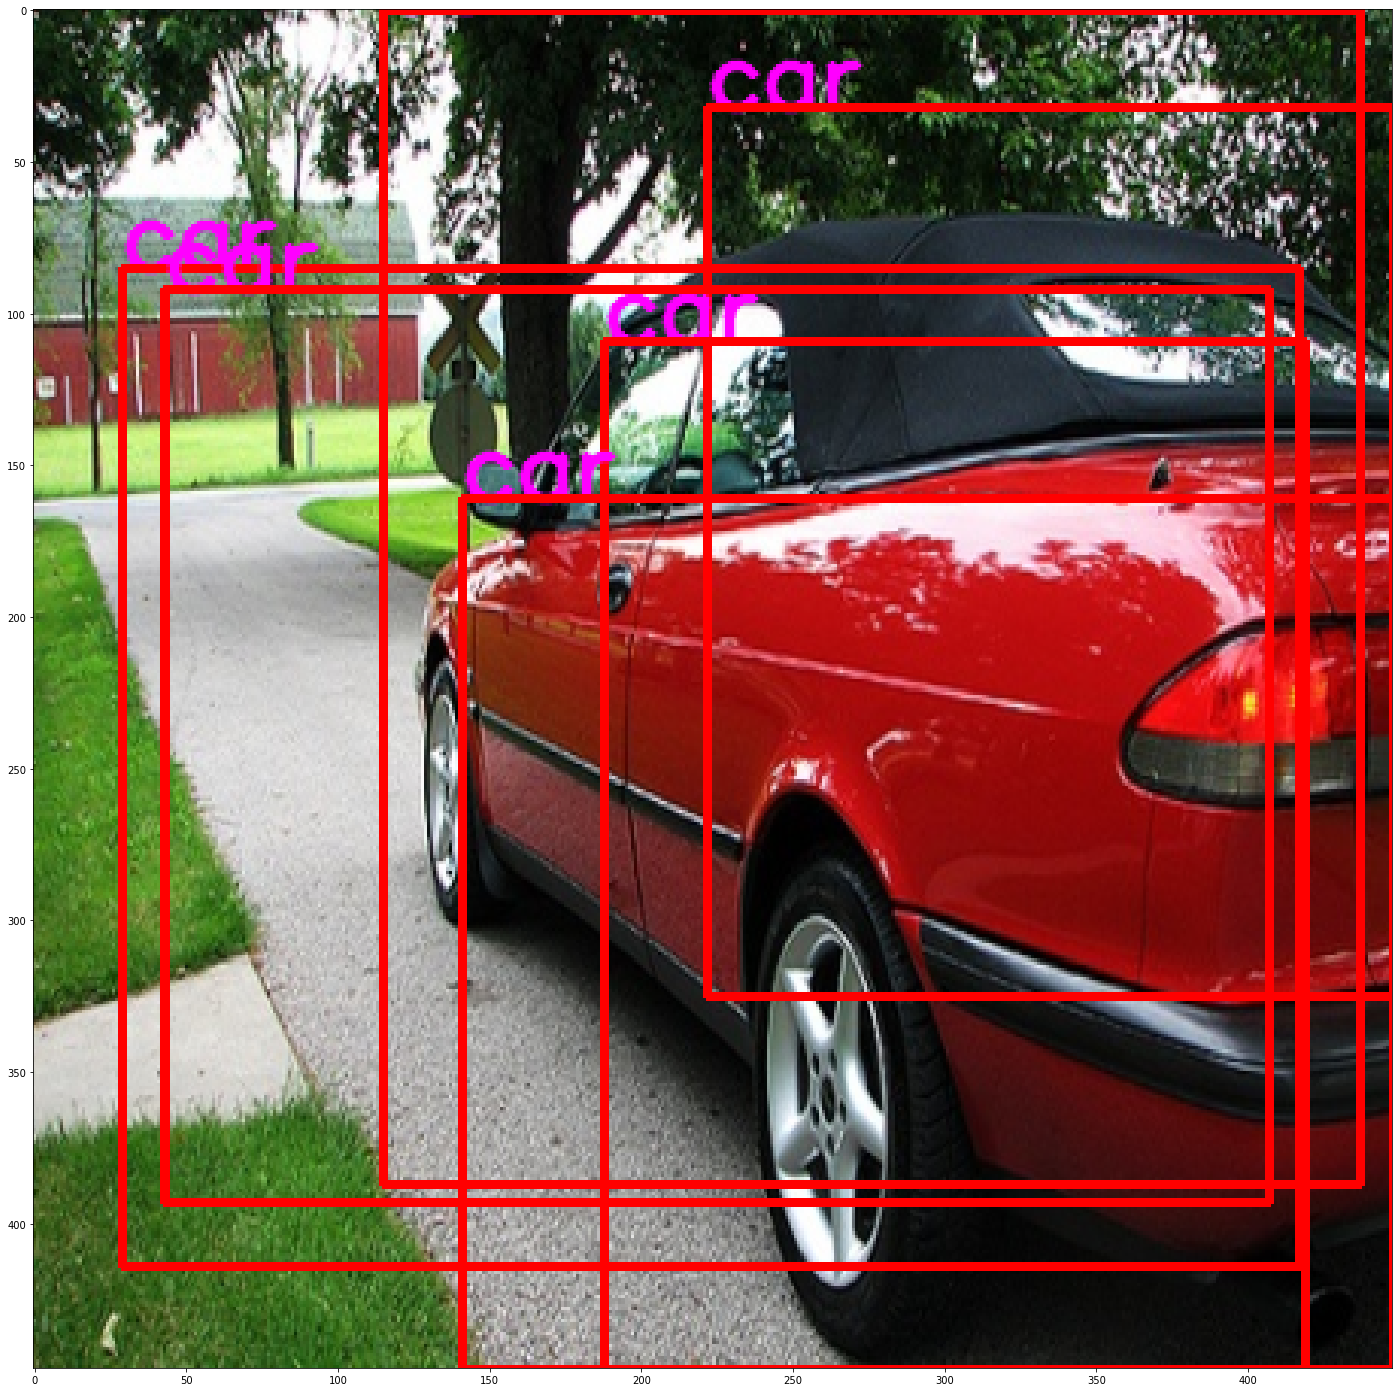

In [35]:
sample ={"image":train[1]["image"],"annotation":preds[1].detach()}
showSample(sample)

In [ ]:
torch.save(model.state_dict(), "trained/mobilnet")